In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Feature Engineering  import
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder ,OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Model import
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Evaluate import
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score ,roc_curve ,classification_report, confusion_matrix

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option("display.precision", 2)
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# EDA
讀取資料，做資料探索

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/大三/下學期/機器學習應用/Datasets/ Bank Marketing/bank-full.csv' ,sep =';')

# df # 45211 rows × 17 columns

In [ ]:
df.info()

In [ ]:
# Numerical statistics
df.describe()

In [ ]:
# Object statistics
df.describe(include=['object'])

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =df ,x ='y')
plt.xticks(rotation=45)
plt.title('y Count')

plt.subplot(1 ,2 ,2)
profile_counts = df['y'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(df['y'].value_counts()) # No:39922(88.3%) ,Yes:5289(11.7%)

得圖表和輸出內容得知,No:39922(88.3%) ,Yes:5289(11.7%)

# Processing Data
刪除特定欄位,做異常值處理

In [ ]:
delete_columns = ['poutcome']
df = df.drop(delete_columns, axis=1)

df = df.drop(4)

In [ ]:
numerical_columns = df.select_dtypes(include='number').columns

for column in numerical_columns:
  # Calculate q1、q3、iqr
  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  iqr = q3 - q1
  # Bound
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  # Outliers
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

  # Reserve
  df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
df # 28068 rows × 16 columns

In [ ]:
# Numerical statistics
df.describe()

# Feature Engineering
將特徵和標籤做特徵工程轉換

In [ ]:
# 標籤y做LabelEncoder
lb_encoder = LabelEncoder()
df['y'] = lb_encoder.fit_transform(df['y'])
# Original values for column 'y': ['no' 'yes']
# Encoded values for column 'y': [0 1]

# 類別特徵欄位做OrdinalEncoder
cat_columns = df.select_dtypes(include='object').columns
or_encoder = OrdinalEncoder()
df[cat_columns] = or_encoder.fit_transform(df[cat_columns])

In [ ]:
df

# Hetmap
做熱力圖,顯示欄位間的相關性，並將絕對值化後的相關性列出

In [ ]:
corr = df.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
correlation_matrix = df.corr().abs()
top_correlations = correlation_matrix['y'].sort_values(ascending=False).head(10)
print(top_correlations)

# Train Test Split

資料分割，將資料集拆分為訓練集和測試集

In [ ]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看全部資料的類別比例
print(pd.Series(y).value_counts(normalize=True))
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

# SMOTE

SMOTE處理資料不平衡

In [ ]:
smote = SMOTE(random_state=42)
X_resample ,y_resample = smote.fit_resample(X, y)

In [ ]:
resampled_data = pd.concat([X_resample, pd.Series(y_resample, name='y')], axis=1)

resampled_data # 53006 rows × 16 columns

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1 ,2 ,1)
sns.countplot(data =resampled_data ,x ='y')
plt.xticks(rotation=45)
plt.title('y Count')

plt.subplot(1 ,2 ,2)
profile_counts = resampled_data['y'].value_counts()
plt.pie(profile_counts, labels = profile_counts.index, autopct='%1.1f%%')
plt.title('y Percentage')
plt.tight_layout()
plt.show()

print(resampled_data['y'].value_counts()) # No:26503(50%) ,Yes:26503(50%)

In [ ]:
X_resample

In [ ]:
y_resample

In [ ]:
X_resample = resampled_data.drop('y' ,axis =1)
y_resample = resampled_data['y']

X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', X_test.shape)
print('='*30)
# 查看訓練集標籤的分佈
print(pd.Series(y_train).value_counts(normalize=True))
# 查看測試集的標籤分佈
print(pd.Series(y_test).value_counts(normalize=True))

# Model

In [ ]:
dtclf_model = DecisionTreeClassifier(random_state=42)

dtclf_model.fit(X_train, y_train)

# Evaluate

In [ ]:
def plot_confusion_matrix(actual_val, pred_val, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                    rownames=['Actual'],
                    colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    if title is not None:
        plot.set_title(title)
    plt.show()

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 訓練集上的模型評分
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(y_train, y_train_pred)

    print("Training Set Evaluation:")
    print("Accuracy:", train_accuracy)
    print("Confusion Matrix:")
    print(train_conf_matrix)
    print("Classification Report:")
    print(train_classification_report)
    print("\n")

    # 測試集上的模型評分
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(y_test, y_test_pred)

    print("Testing Set Evaluation:")
    print("Accuracy:", test_accuracy)
    print("Confusion Matrix:")
    print(test_conf_matrix)
    print("Classification Report:")
    print(test_classification_report)

    plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix")

evaluate_model_performance(dtclf_model, X_train, X_test, y_train, y_test)

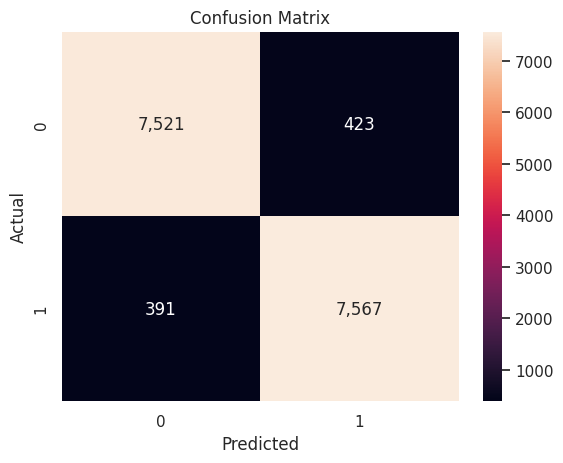

y - 顧客是否已認購定期存款

*   有認購定期存款資料總共有˙7958筆，其中7567筆被成功辨識出來，391筆沒有被辨識出來。
*   沒有認購的資料總共有7944筆，其中有423筆資料沒認購被預測為有認購，剩下的7521筆預測皆正確。

經過異常值和處理標籤類別不平衡的問題後，使用DecisionTreeClassifier來做學習，測試的結果表現良好，但在訓練上疑似有些許的過擬和問題產生，之後可嘗試Ensemble learning algorithm( RandomForest、XGBoost、LightGBM)。


# Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1)
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

    plt.legend(loc="best")
    plt.show()
plot_learning_curve(dtclf_model, X_train, y_train)

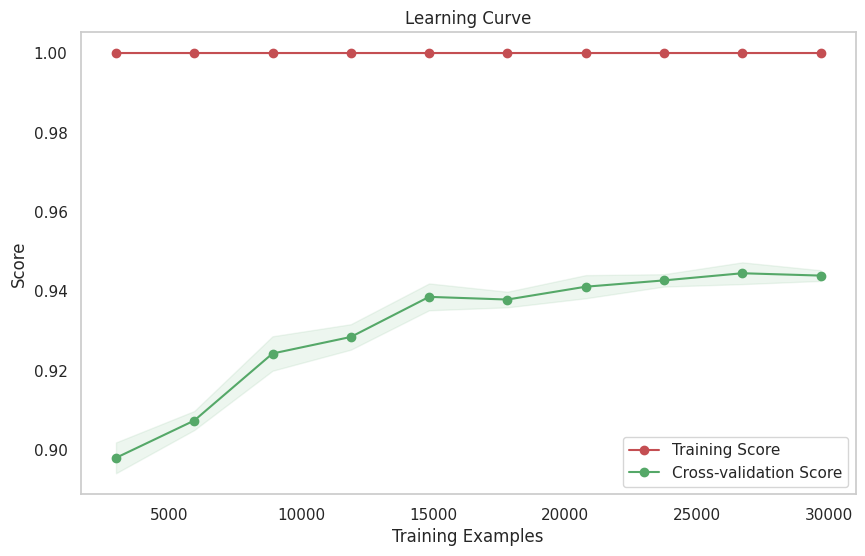

# GridSearchCV

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search
grid_search = GridSearchCV(dtclf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

In [ ]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

test_accuracy = best_estimator.score(X_test, y_test)
print("\nTest Accuracy:", test_accuracy)

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix for Test Set:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()